# Import Libraries & Data

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from my_module import *
from IPython.core.display import display, HTML
display(HTML('<style>.container { width:80% !important; }</style>'))
scaler = StandardScaler()

## Data

In [2]:
df = pd.read_csv('yelp_review_processed.csv')
with pd.option_context('display.max_colwidth', 20):
    display(df.head())

,review,review_clean,review_stars,set_word,number_of_photos,number_of_price,number_of_time,number_of_emots,average_useful_vote,review_age_days,review_useful
0,"""River, we see t...",river yelp place...,5.0,159,0,0,0,0,2.375,2157,6
1,Gave this restau...,give restaur sta...,3.0,133,0,0,1,5,0.000,2331,0
2,Oh boy! I love v...,boy love veggi r...,4.0,103,0,0,0,2,0.000,1245,0
3,This was my firs...,vegan meal famil...,5.0,33,0,0,0,0,0.000,1417,0
4,Visited the Vegg...,visit veggi hous...,5.0,72,0,0,0,1,0.000,1853,0


In [3]:
# only use text and extracted qualitative features
X = df.drop(['review_clean', 'review_useful'], axis=1)
# all reviews which have 5 or greater helpful votes are labeled as helpful
# all other reviews are in the not helpful category
y = np.where(df.review_useful > 4, 1, 0)

In [4]:
# split into train and test set
X_train, X_test, y_train, y_test = train_test_split(
                                        X, y, test_size=0.2, random_state=1)
print("""
        Number of helpful reviews in the training data: {:,}
        Number of helpful reviews in the test data: {:,}
        
        Distribution of the positive class in the training data: {:.2f}%
        Distribution of the positive class in the test data: {:.2f}%
        
        The class distributions are pretty close both in the training and the
        test data which will ensure the stability of the algorithms.
      """
      .format(y_train.sum(), y_test.sum(),
              (y_train[y_train == 1].size / y_train.size) * 100, 
              (y_test[y_test == 1].size / y_test.size) * 100))


        Number of helpful reviews in the training data: 29,462
        Number of helpful reviews in the test data: 7,483
        
        Distribution of the positive class in the training data: 5.03%
        Distribution of the positive class in the test data: 5.11%
        
        The class distributions are pretty close both in the training and the
        test data which will ensure the stability of the algorithms.
      


In [5]:
# will be used later to determine model performance
temp = X_test.loc[:, 'review'].to_frame()
temp = temp.merge(df.loc[temp.index, 'review_useful'], left_index=True, right_index=True)
top_10_helpful_votes = sorted(temp.review_useful.unique(), reverse=True)[:10]
temp['is_top_10'] = temp.review_useful.isin(top_10_helpful_votes).astype(np.int)
temp.head()

,review,review_useful,is_top_10
449320,Simply delicious. I had the pork chop and my c...,0,0
198748,"Great menu, great beers, huge enormous giganti...",0,0
86433,Came here for lunch while staying at Aria. Def...,0,0
79060,"This casual, contempary joint reminds me of a ...",3,0
27334,Went to the dog park up the road and grabbed s...,2,0


In [6]:
X_train = X_train.drop('review', axis=1).values
X_test = X_test.drop('review', axis=1).values

# Train the Models

In [7]:
lr = LogisticRegression(C=100, class_weight='balanced', solver='lbfgs')
dt = DecisionTreeClassifier()
rf = RandomForestClassifier(class_weight='balanced', max_features='log2', n_estimators=1000)
et = ExtraTreesClassifier(max_features='log2', n_estimators=1000)
xgb = XGBClassifier(colsample_bytree=0.8, eta=0.1)
knn = KNeighborsClassifier(n_neighbors=20)

In [8]:
estimators = [('Logistic Regression', lr),
              ('KNN Classifier', knn),
              ('Decision Tree Classifier', dt),
              ('Random Forest Classifier', rf),
              ('Extra Trees Classifier', et),
              ('XGBoost Classifier', xgb)]
scalers = [True, True, False, False, False, False, False, False]
training_scores = train_model(
    estimators=estimators, X=X_train, y=y_train, scalers=scalers)
training_scores_, _ = calculate_statistics(training_scores)
df_training = make_df_statistics(training_scores_)
df_training

,matthews_corrcoef,roc_auc_score,pr_auc_score
Logistic Regression,0.574228,0.976031,0.726150
KNN Classifier,0.639759,0.981817,0.775516
Decision Tree Classifier,0.999946,1.000000,1.000000
Random Forest Classifier,0.999946,1.000000,0.999999
Extra Trees Classifier,0.999946,1.000000,1.000000
XGBoost Classifier,0.688801,0.982024,0.793842


# Test the Models

In [9]:
test_scores = test_model(estimators=estimators,
                         X=X_test, y=y_test, scalers=scalers)
test_scores_, _ = calculate_statistics(test_scores)
df_test = make_df_statistics(test_scores_)
df_test

,matthews_corrcoef,roc_auc_score,pr_auc_score
Logistic Regression,0.568460,0.976048,0.727485
KNN Classifier,0.634249,0.952136,0.720750
Decision Tree Classifier,0.566798,0.786743,0.599545
Random Forest Classifier,0.670891,0.975811,0.761810
Extra Trees Classifier,0.655883,0.972227,0.738475
XGBoost Classifier,0.685592,0.980665,0.783915


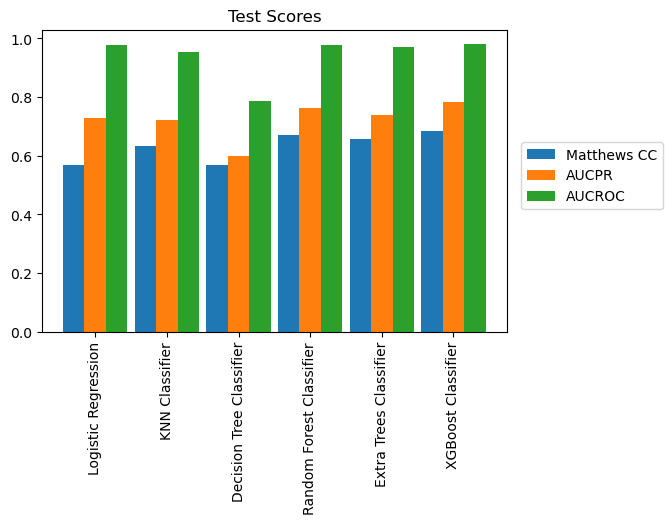

In [10]:
fig, ax = plt.subplots()  # generates figure and axes object
fig.set_dpi(100)  # set the resolution of the plot
width = 0.3  # set bar width
idx = np.arange(
    df_test.shape[0])  # number of ticks for x-axis and bar location
# plots matthews correlation coef.
ax.bar(idx, df_test.matthews_corrcoef, width)
ax.bar(idx + width, df_test.pr_auc_score, width)  # plots AUCPR
ax.bar(idx + width * 2, df_test.roc_auc_score, width)
ax.set_xticks(idx + 0.3)  # adjust the position of xticks
ax.set_xticklabels(df_test.index, rotation=90)  # changes the tick labels
ax.legend(['Matthews CC', 'AUCPR', 'AUCROC'],
          bbox_to_anchor=(1.35, 0.65))  # set the legend
ax.set_title('Test Scores')
plt.show()  # shows the plot

# Confusion Matrices

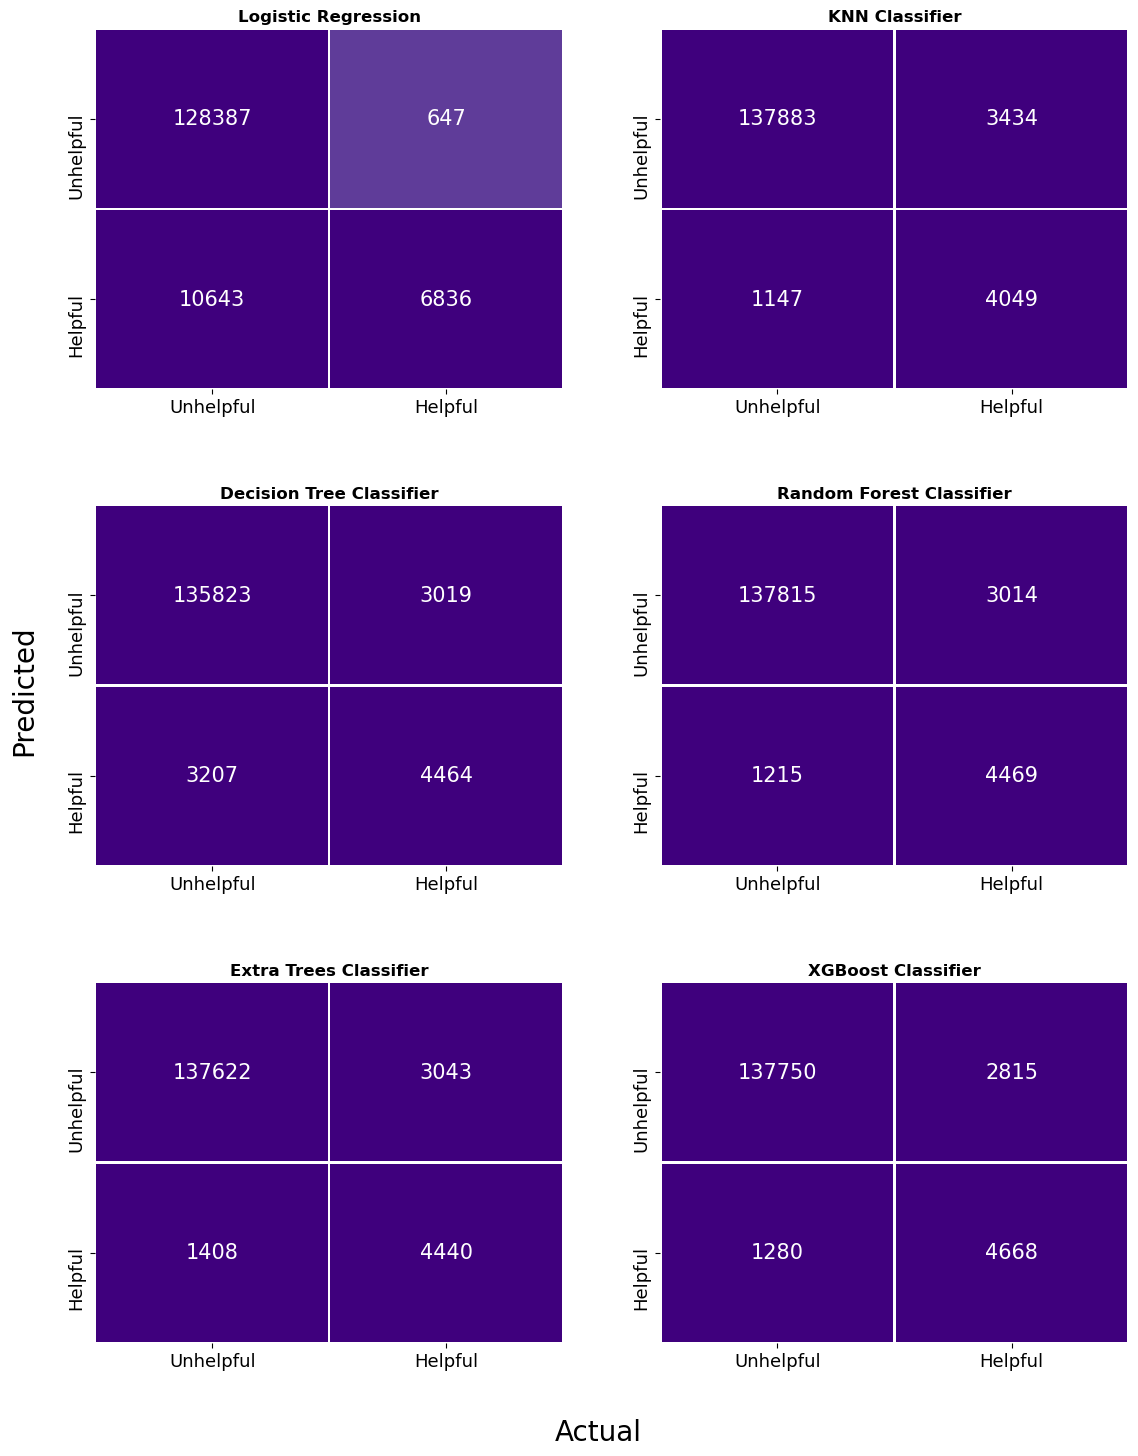

In [11]:
predicted_values_all = []
for model in df_test.index:
    predicted_values_all.append(test_scores[model]['predictions'][0])

fig, axes = plt.subplots(3, 2, figsize=(12, 15))
fig.set_dpi(100)
axes = axes.ravel()

for idx, model in enumerate(df_test.index):
    plot_confusion_matrix(
        y=y_test, predictions=predicted_values_all[idx], title=model, ax=axes[idx], ticklabels=['Unhelpful', 'Helpful'], cmap='Purples', cbar=False)
fig.text(0.5, 0, 'Actual', ha='center', size=20)
fig.text(0.01, 0.5, 'Predicted', va='center', size=20, rotation='vertical')
plt.tight_layout(5)
plt.show()

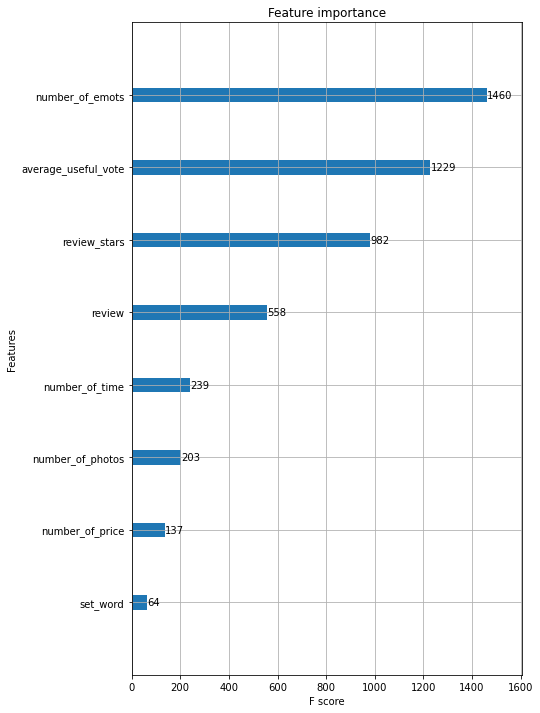

In [12]:
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(7, 12))
xgb.get_booster().feature_names = list(df.drop(['review_clean',
                                                'review_useful'], axis=1).columns)
plot_importance(xgb, ax=ax)
plt.show()

# Check Top Predicted Useful Reviews

In [13]:
print("""
        Among {:,} reviews in the test data, {:,} reviews are among those that 
        have one of the top 10 helpful votes.
      """
      .format(temp.shape[0], temp.is_top_10.values.sum()))


        Among 146,513 reviews in the test data, 11 reviews are among those that 
        have one of the top 10 helpful votes.
      


        Top 10 helpful votes are decided by taking the unique values in among
        the helpful votes, arranging them in descending order and taking the
        first 10 number of helpful votes. For this reason, there may be more
        than 10 review which have the highest 10 helpful votes.
        
        The aim is to decide, firstly, if an algorithm is able to distinguish
        helpful reviews from unhelpful reviews. Secondly, among those reviews
        that are predicted to be helpful, how may reviews are among the reviews
        that have top 10 helpful votes.
        
        In other words, we would like to measure how many of the predicted helpful
        reviews will be among the reviews that have the highest helpful votes
        in the real life.
        
        It is easy to come up with predictions but we would like to determine
        the also the quality of those predictions.

        In the confusion matrices, we see that:
            1. Logistic Regression predicted the highest number of useful review in expense of false positives.
               Moreover, it has the lowest false negative rate among all algorithms.
            2. KNN predicted an average number of useful reviews with the lowest false positive rate.
               However, it has the greatest number of false negatives.
            3. All other algorithms stays in the spectrum where the edges are Logistic Regression and KNN algorithms.
               Among the remaining algorithms, Random Forest and XGBoost algorithms are the top algorithms.

        In this stage, we will look the top 30 helpful reviews predicted by all algorithms and their true helpful votes.
        This kind of approach will provide better understanding of the results. The aim is to find the algorithm which
        predicted the helpful reviews which has the highest true votes with the highest precision.

## Logistic Regression

In [14]:
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [15]:
lr = LogisticRegression(C=100, class_weight='balanced', solver='lbfgs')
lr.fit(X_train_scaled, y_train)
predicted_probas_lr = lr.predict_proba(X_test_scaled)
predicted_probas_lr = [round(proba[1], 4) for proba in predicted_probas_lr]
temp['lr_probas'] = predicted_probas_lr

In [16]:
with pd.option_context('display.max_row', None):
    display(temp.sort_values(['lr_probas','review_useful'], ascending=[False, False]).head(30))

,review,review_useful,is_top_10,lr_probas
120715,Eggslut has opened a few locations in the Los ...,213,1,1.0
173345,"""Food is such a powerful lil hoe, she could ta...",162,1,1.0
401294,DO NOT VISIT THIS CASINO! There were a ton of ...,161,1,1.0
82531,"Shang's commitment to quality ingredients, fri...",139,1,1.0
620450,"Charlie Rose: ""Here's the big question: Is Dav...",138,1,1.0
510665,I respect Chef José Andrés immensely but I can...,133,1,1.0
58714,"Lawry's Fact: They serve 750,000 lbs. of meat...",130,1,1.0
185348,Eating at Nobu is like breaking out an old rec...,124,1,1.0
404570,One day after a meeting my coworker and I stop...,121,1,1.0
71239,We were on our way to a very late breakfast at...,117,1,1.0


## KNN

In [17]:
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X_train_scaled, y_train)
predicted_probas_knn = knn.predict_proba(X_test_scaled)
predicted_probas_knn = [round(proba[1], 4) for proba in predicted_probas_knn]
temp['knn_probas'] = predicted_probas_knn

In [18]:
with pd.option_context('display.max_row', None):
    display(temp.sort_values(['knn_probas','review_useful'], ascending=[False, False]).head(30))

,review,review_useful,is_top_10,lr_probas,knn_probas
173345,"""Food is such a powerful lil hoe, she could ta...",162,1,1.0,1.0
401294,DO NOT VISIT THIS CASINO! There were a ton of ...,161,1,1.0,1.0
82531,"Shang's commitment to quality ingredients, fri...",139,1,1.0,1.0
620450,"Charlie Rose: ""Here's the big question: Is Dav...",138,1,1.0,1.0
510665,I respect Chef José Andrés immensely but I can...,133,1,1.0,1.0
58714,"Lawry's Fact: They serve 750,000 lbs. of meat...",130,1,1.0,1.0
185348,Eating at Nobu is like breaking out an old rec...,124,1,1.0,1.0
404570,One day after a meeting my coworker and I stop...,121,1,1.0,1.0
573605,I like hashtags because they look like waffles...,117,1,1.0,1.0
186493,It's hard to even imagine that what was once a...,112,0,1.0,1.0


## Decision Tree

In [19]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
predicted_probas_dt = dt.predict_proba(X_test)
predicted_probas_dt = [round(proba[1], 4) for proba in predicted_probas_dt]
temp['dt_probas'] = predicted_probas_dt

In [20]:
with pd.option_context('display.max_row', None):
    display(temp.sort_values(['dt_probas','review_useful'], ascending=[False, False]).head(30))

,review,review_useful,is_top_10,lr_probas,knn_probas,dt_probas
120715,Eggslut has opened a few locations in the Los ...,213,1,1.0,0.95,1.0
173345,"""Food is such a powerful lil hoe, she could ta...",162,1,1.0,1.00,1.0
401294,DO NOT VISIT THIS CASINO! There were a ton of ...,161,1,1.0,1.00,1.0
82531,"Shang's commitment to quality ingredients, fri...",139,1,1.0,1.00,1.0
620450,"Charlie Rose: ""Here's the big question: Is Dav...",138,1,1.0,1.00,1.0
510665,I respect Chef José Andrés immensely but I can...,133,1,1.0,1.00,1.0
58714,"Lawry's Fact: They serve 750,000 lbs. of meat...",130,1,1.0,1.00,1.0
185348,Eating at Nobu is like breaking out an old rec...,124,1,1.0,1.00,1.0
404570,One day after a meeting my coworker and I stop...,121,1,1.0,1.00,1.0
71239,We were on our way to a very late breakfast at...,117,1,1.0,0.95,1.0


## Random Forest

In [21]:
rf = RandomForestClassifier(class_weight='balanced', max_features='log2', n_estimators=1000)
rf.fit(X_train, y_train)
predicted_probas_rf = rf.predict_proba(X_test)
predicted_probas_rf = [round(proba[1], 4) for proba in predicted_probas_rf]
temp['rf_probas'] = predicted_probas_rf

In [22]:
with pd.option_context('display.max_row', None):
    display(temp.sort_values(['rf_probas','review_useful'], ascending=[False, False]).head(30))

,review,review_useful,is_top_10,lr_probas,knn_probas,dt_probas,rf_probas
25905,Love him or hate him... the then candidate Mr....,44,0,1.0000,1.00,1.0,1.000
562885,Your eyes don't deceive you...The Mirage is tr...,42,0,1.0000,1.00,1.0,0.999
208209,It's not always I can eat Indian food. It tend...,29,0,1.0000,1.00,1.0,0.999
620450,"Charlie Rose: ""Here's the big question: Is Dav...",138,1,1.0000,1.00,1.0,0.998
50167,Having heard great things about Mesa Grill for...,48,0,1.0000,1.00,1.0,0.998
577215,I found my spot. How have I been missing out!?...,23,0,1.0000,1.00,1.0,0.998
518855,One look at the Mac N' Cheese Chicken Tender W...,23,0,1.0000,0.95,1.0,0.998
135915,"OK, this place has been on my bookmarks for se...",36,0,1.0000,1.00,1.0,0.997
313856,"I'm not a golfer by any means, but still had a...",35,0,1.0000,1.00,1.0,0.997
144765,For fear of being scolded by Mr. Ramsay I will...,30,0,1.0000,0.90,1.0,0.997


## Extra Trees

In [23]:
et = ExtraTreesClassifier(max_features='log2', n_estimators=1000)
et.fit(X_train, y_train)
predicted_probas_et = et.predict_proba(X_test)
predicted_probas_et = [round(proba[1], 4) for proba in predicted_probas_et]
temp['et_probas'] = predicted_probas_et

In [24]:
with pd.option_context('display.max_row', None):
    display(temp.sort_values(['et_probas','review_useful'], ascending=[False, False]).head(30))

,review,review_useful,is_top_10,lr_probas,knn_probas,dt_probas,rf_probas,et_probas
283685,"Come hungry, leave happy. How hungry are you? ...",91,0,1.0000,1.00,1.0,0.984,1.000
328023,We had some people for out of town visiting an...,53,0,1.0000,0.95,1.0,0.993,1.000
535779,Had planned to meet up with Yelp buds Angela T...,49,0,1.0000,1.00,1.0,0.995,1.000
135915,"OK, this place has been on my bookmarks for se...",36,0,1.0000,1.00,1.0,0.997,1.000
609242,The food here is delicious! No matter what you...,2,0,0.1810,0.05,1.0,0.643,1.000
183165,the slider trio was excellent the slaw on the ...,0,0,0.9780,0.55,1.0,0.794,1.000
82354,"I'm a big fan of noodle, it has such a magical...",70,0,1.0000,1.00,1.0,0.994,0.999
34738,Another fun Fremont Street Experience Area Hot...,47,0,1.0000,1.00,1.0,0.979,0.999
313856,"I'm not a golfer by any means, but still had a...",35,0,1.0000,1.00,1.0,0.997,0.999
693825,Both times that I have been to the Sicilian Bu...,25,0,1.0000,0.95,1.0,0.997,0.999


## XGBoost Classifier

In [25]:
xgb = XGBClassifier(colsample_bytree=0.8, eta=0.1)
xgb.fit(X_train, y_train)
predicted_probas_xgb = xgb.predict_proba(X_test)
predicted_probas_xgb = [round(proba[1], 4) for proba in predicted_probas_xgb]
temp['xgb_probas'] = predicted_probas_xgb

In [26]:
with pd.option_context('display.max_row', None):
    display(temp.sort_values(['xgb_probas','review_useful'], ascending=[False, False]).head(30))

,review,review_useful,is_top_10,lr_probas,knn_probas,dt_probas,rf_probas,et_probas,xgb_probas
620450,"Charlie Rose: ""Here's the big question: Is Dav...",138,1,1.0,1.00,1.0,0.998,0.997,0.9963
315946,Bonjour Paris without the flight. This is by f...,28,0,1.0,1.00,1.0,0.988,0.979,0.9951
620155,I really have a love hate relationship with Mo...,71,0,1.0,1.00,1.0,0.976,0.977,0.9948
237362,Bobby Flay seems to be everywhere these days. ...,34,0,1.0,0.90,1.0,0.959,0.972,0.9943
570478,Sage is located in the Aria Hotel. The ambian...,29,0,1.0,0.85,1.0,0.988,0.983,0.9942
82354,"I'm a big fan of noodle, it has such a magical...",70,0,1.0,1.00,1.0,0.994,0.999,0.9940
50167,Having heard great things about Mesa Grill for...,48,0,1.0,1.00,1.0,0.998,0.997,0.9940
25905,Love him or hate him... the then candidate Mr....,44,0,1.0,1.00,1.0,1.000,0.995,0.9940
341757,"""This beautiful woman just literally tripped a...",43,0,1.0,1.00,1.0,0.982,0.992,0.9938
2864,Cafe Sanuki is a Japanese cafeteria style rest...,35,0,1.0,1.00,1.0,0.978,0.980,0.9937


In [27]:
threshold = 0.95  # confidence threshold for algorithms
print("""
        The recall ratio for predicted helpful reviews with 0.95 confidence
        (the reviews that have assigned probability 0.95 or above):    
        
            * {:<20}\t{:.2f}%\t{:>6,} out of {:>5,}
            * {:<20}\t{:.2f}%\t{:>6,} out of {:>5,}
            * {:<20}\t{:.2f}%\t{:>6,} out of {:>5,}
            * {:<20}\t{:.2f}%\t{:>6,} out of {:>5,}
            * {:<20}\t{:.2f}%\t{:>6,} out of {:>5,}
            * {:<20}\t{:.2f}%\t{:>6,} out of {:>5,}
      """.format(
    'Logistic Regression',
    (temp[(temp.lr_probas >= threshold) & (temp.review_useful >= 5)].shape[0] /
    temp[temp.lr_probas >= threshold].shape[0]) * 100,
    temp[(temp.lr_probas >= threshold) & (temp.review_useful >= 5)].shape[0],
    temp[(temp.lr_probas >= threshold)].shape[0],
    'KNN',
    (temp[(temp.knn_probas >= threshold) & (temp.review_useful >= 5)].shape[0] /
    temp[temp.knn_probas >= threshold].shape[0]) * 100,
    temp[(temp.knn_probas >= threshold) & (temp.review_useful >= 5)].shape[0],
    temp[(temp.knn_probas >= threshold)].shape[0],
    'Decision Tree',
    (temp[(temp.dt_probas >= threshold) & (temp.review_useful >= 5)].shape[0] /
    temp[temp.dt_probas >= threshold].shape[0]) * 100,
    temp[(temp.dt_probas >= threshold) & (temp.review_useful >= 5)].shape[0],
    temp[(temp.dt_probas >= threshold)].shape[0],
    'Random Forest',
    (temp[(temp.rf_probas >= threshold) & (temp.review_useful >= 5)].shape[0] /
    temp[temp.rf_probas >= threshold].shape[0]) * 100,
    temp[(temp.rf_probas >= threshold) & (temp.review_useful >= 5)].shape[0],
    temp[(temp.rf_probas >= threshold)].shape[0],
    'Extra Trees',
    (temp[(temp.et_probas >= threshold) & (temp.review_useful >= 5)].shape[0] /
    temp[temp.et_probas >= threshold].shape[0]) * 100,
    temp[(temp.et_probas >= threshold) & (temp.review_useful >= 5)].shape[0],
    temp[(temp.et_probas >= threshold)].shape[0],
    'XGBoost',
    (temp[(temp.xgb_probas >= threshold) & (temp.review_useful >= 5)].shape[0] /
    temp[temp.xgb_probas >= threshold].shape[0]) * 100,
    temp[(temp.xgb_probas >= threshold) & (temp.review_useful >= 5)].shape[0],
    temp[(temp.xgb_probas >= threshold)].shape[0]))


        The recall ratio for predicted helpful reviews with 0.95 confidence
        (the reviews that have assigned probability 0.95 or above):    
        
            * Logistic Regression 	71.98%	 4,853 out of 6,742
            * KNN                 	95.16%	   904 out of   950
            * Decision Tree       	58.22%	 4,509 out of 7,745
            * Random Forest       	96.80%	   695 out of   718
            * Extra Trees         	95.69%	   599 out of   626
            * XGBoost             	97.91%	   656 out of   670
      


        As we discussed in the confusion matrices section, XGBoost and Random Forest
        are the top algorithms. We can also see that from the recall rates, the ratio
        of true helpful reviews to predicted helpful reviews for the reviews that have
        0.95 or above assigned probability, are the highest among all algorithms.
        
        Another important point is that Decision Tree and Logistic Regression have the
        lowest recall rate among all algorithms. However, they are better than all other
        algorithms in terms of predicting the true helpful reviews with the highest 
        helpful votes. For this reason, we can say that Logistic Regression and Decision
        Tree have a naiver approach than all other algorithms. 
        
        In this project, our perspective is not solely to approach the problem as a pure
        classification problem but to be able to recommend among the freshly posted reviews
        that would have the highest helpful votes.
        
        Finally we will investigate how much success an algorithm has identifying the
        helpful reviews that have the highest number of helpful votes. Since those reviews
        are at the top they should have assigned probabilities that are close to 1.0.
        

In [28]:
N = temp.is_top_10.sum()

print("""       
        * {:<20}\t{:>3,} out of {:>2,}
        * {:<20}\t{:>3,} out of {:>2,}
        * {:<20}\t{:>3,} out of {:>2,}
        * {:<20}\t{:>3,} out of {:>2,}
        * {:<20}\t{:>3,} out of {:>2,}
        * {:<20}\t{:>3,} out of {:>2,}   
      """
      .format(
      'Logistic Regression',
      temp[temp.lr_probas >= threshold].is_top_10.sum(), N,
      'KNN',
      temp[temp.knn_probas >= threshold].is_top_10.sum(), N,
      'Decision Tree',
      temp[temp.dt_probas >= threshold].is_top_10.sum(), N,
      'Random Forest',
      temp[temp.rf_probas >= threshold].is_top_10.sum(), N,
      'Extra Trees',
      temp[temp.et_probas >= threshold].is_top_10.sum(), N,
      'XGBoost',
      temp[temp.xgb_probas >= threshold].is_top_10.sum(), N))

       
        * Logistic Regression 	 11 out of 11
        * KNN                 	 11 out of 11
        * Decision Tree       	 11 out of 11
        * Random Forest       	  6 out of 11
        * Extra Trees         	  9 out of 11
        * XGBoost             	  8 out of 11   
      


        Almost all reviews, except Random Forest, are able to predict the all of the helpful reviews
        that have the highest number of helpful votes. 
        
        All being said that XGBoost is the best algorithm in terms of predicting helpful reviews.
        We set 0.95 as the threshold for the assigned probabilities in order to increase the recall rate.
        By doing this, we hope to avoid false positives so that the business owners (the restaurants in
        this case) will be more likely to provide the customers with the reviews that can attract their
        attention and present what they are looking for. Also, they can promote those reviews among the
        others so that it will be easier for the customers to reach the relevant information about the
        business and the product(s).

# The Learning Curve

        In this section, we will asses the performance of XGBoost algorithm with respect to different sizes
        of training set in order to see how performance changes based on the number of reviews.

In [29]:
# get random numbers as indices
train_1k_idx = np.random.randint(X_train.shape[0], size=1000)
train_10k_idx = np.random.randint(X_train.shape[0], size=10000)
train_50k_idx = np.random.randint(X_train.shape[0], size=50000)
train_100k_idx = np.random.randint(X_train.shape[0], size=100000)
train_250k_idx = np.random.randint(X_train.shape[0], size=250000)

In [30]:
# set training sets in different sizes
train_1k = X_train[train_1k_idx]
train_10k = X_train[train_10k_idx]
train_50k = X_train[train_50k_idx]
train_100k = X_train[train_100k_idx]
train_250k = X_train[train_250k_idx]

In [31]:
# set the target variable using the same indices
test_1k = y_train[train_1k_idx]
test_10k = y_train[train_10k_idx]
test_50k = y_train[train_50k_idx]
test_100k = y_train[train_100k_idx]
test_250k = y_train[train_250k_idx]

In [32]:
training_sets = [train_1k, train_10k, train_50k, train_100k, train_250k, X_train]
validation_sets = [test_1k, test_10k, test_50k, test_100k, test_250k, y_train]
sets = ['train_1k', 'train_10k', 'train_50k', 'train_100k', 'train_250k', 'train_all']

# dict to store metrics
d = {set : {} for set in sets}

In [33]:
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

for x_train, y_validation, set_name in zip(training_sets, validation_sets, sets):
    xgb = XGBClassifier()
    xgb.fit(x_train, y_validation)
    predictions = xgb.predict(X_test)
    
    f1Score = f1_score(y_test, predictions)
    recallScore = recall_score(y_test, predictions)
    matthews = matthews_corrcoef(y_test, predictions)
    
    d[set_name]['recall_score'] = recallScore
    d[set_name]['f1_score'] = f1Score
    d[set_name]['matthews'] = matthews

In [34]:
recallScores = [d[set_name]['recall_score'] for set_name in sets]
f1Scores = [d[set_name]['f1_score'] for set_name in sets]
matthewsScores = [d[set_name]['matthews'] for set_name in sets]

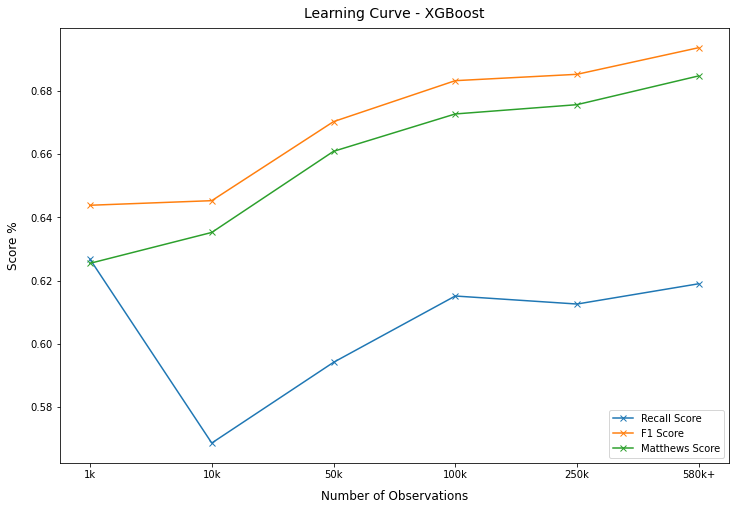

In [35]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(recallScores, label='Recall Score', marker='x')
ax.plot(f1Scores, label='F1 Score', marker='x')
ax.plot(matthewsScores, label='Matthews Score', marker='x')
ax.set_xticks(range(len(sets)))
ax.set_xticklabels(['1k', '10k', '50k', '100k', '250k', '580k+'])
ax.legend(loc='lower right')
ax.set_xlabel('Number of Observations', labelpad=10, size=12)
ax.set_ylabel('Score %', labelpad=10, size=12)
ax.set_title('Learning Curve - XGBoost', pad=10, size=14)
plt.show()

        As seen from the plot, the algorithm get better and better as the we feed it with more data.

# Examples

In [36]:
indices = temp[temp.xgb_probas >= 0.95].index
idx = np.random.randint(len(indices), size=7)
indices = list(indices[idx])

In [37]:
for idx in indices:
    print("""
            The number of helpful votes: {}
            
          """.format(df.iloc[idx].review_useful))
    print(df.iloc[idx].review)
    print('-+' * 80)


            The number of helpful votes: 17
            
          
O.H.S.O is some sort of strange amalgamation of a craft beer bar and casual dinning. Still, this place is a solid choice for a meal, especially if you are a beer nerd AND foodie. They boast a variety of burgers, salads, flatbreads, and tacos. However, I'm a firm believer that their brunch menu is O.H.S.O's greatest strength.

I arrived during late morning with a group of groomsmen and the first thing we noticed (aside from the beer menu) was the brunch special. Choose one item from the brunch menu plus 10oz of any Arizona beer or 1 mimosa for only $10.99. They have a carnitas bowl, some flatbreads, and more typical items such as biscuits and gravy, but I went with a breakfast wrap! Who could say "no" to eggs, bacon, potatoes, guacamole, cheese, and salsa wrapped up in whole wheat? Came with a side of fruit too! It was pretty tasty.I prefer my food to have a bit of a kick so hot sauce was necessary. 

As for the beer, 